# Inference of parameters with latent variables (SEAIRQ model)

In this notebook, we consider the SEAIRQ model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, and quarantined. We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 

when partially observed data ($Q$ only) from a generated trajectory. Here, $Q$ can be regarded as the number of confirmed cases (which are properly quarantined), which is in a realistic scenario the only observable stage.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 1./5           # rate Is -> Q, five days for symptomatic people to be tested and quarantined 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([100, 100])
A0  = np.array([10, 10])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEAIRQ_traj.npy', data_array)

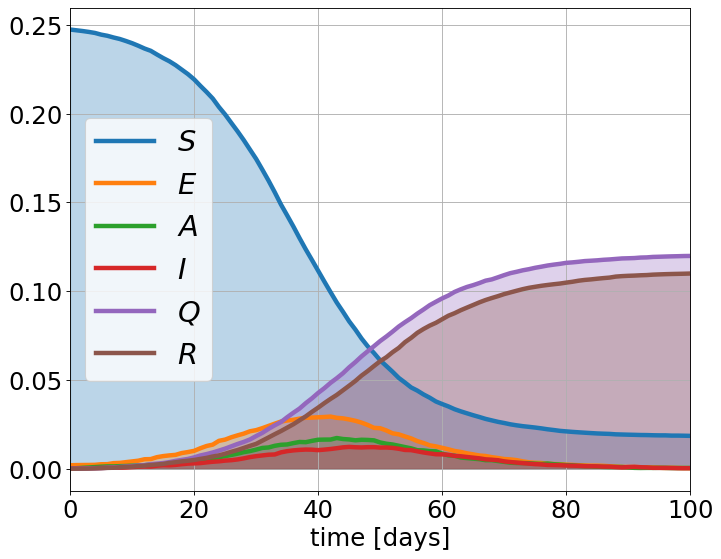

In [4]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0*M]
E  = data_array[:,1*M]
A  = data_array[:,2*M]
Ia = data_array[:,3*M]
Is = data_array[:,4*M]
Q  = data_array[:,5*M]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="C0", alpha=0.3)
plt.plot(t, S/N, '-', color="C0", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="C1", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='C1', alpha=0.3)

plt.plot(t, A/N, '-', color="C2", label='$A$', lw=4)
plt.fill_between(t, 0, A/N, color='C2', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='C3', alpha=0.3)
plt.plot(t, Is/N, '-', color='C3', label='$I$', lw=4)

plt.fill_between(t, 0, Q/N, color='C4', alpha=0.3)
plt.plot(t, Q/N, '-', color='C4', label='$Q$', lw=4)

R=Ni[0]-S-Ia-Is-E-A-Q; 
plt.fill_between(t, 0, R/N, color="C5", alpha=0.3)
plt.plot(t, R/N, '-', color="C5", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Inference
We take the first $40$ data points of the $Q$ trajectory and use it to infer the parameters of the model.

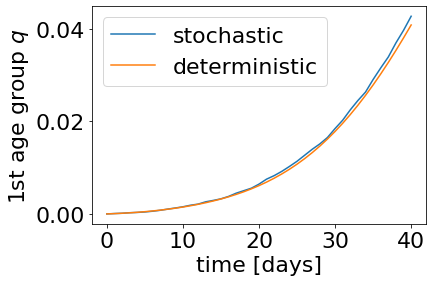

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEAIRQ_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, False, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = pyross.deterministic.SEAIRQ(parameters, int(M), fi)
xm = estimator.integrate(x[0,:], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
plt.plot(x[:,5*M],label="stochastic")
plt.plot(xm[:,5*M],label="deterministic")
plt.xlabel("time [days]")
plt.ylabel("1st age group $q$")
plt.legend()
plt.show()


In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-606.1387850826343
0.4942328929901123


In [18]:
# make parameter guesses and set up bounds for each parameter 

alpha_g = 0.22
alpha_std = 0.05 
eps=1e-4
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.04 
beta_bounds = (eps, 1)

gE_g = 0.3
gE_std = 0.2 
gE_bounds = (eps, 1)

gA_g = 0.3
gA_std = 0.2 
gA_bounds = (eps, 1)

gIa_g = 0.1
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.1
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

fsa_g = 0.8 # not inferred 

E0_g = E0/N 
E_std = E0_g*0.2 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

A0_g = (A0-3)/N 
A_std = A0_g*0.4
bounds_for_A = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

#Q0_g = np.tile(eps,M)
#Q_std = np.tile(eps,M) # known exactly to be zero
#bounds_for_Q = np.tile([0, 0.1/N], M).reshape(M, 2)

Q0_g = np.tile(1,M)/N
Q_std = Q0_g # we know that Q0 is zero exactly, but the optimiser can't handle this
bounds_for_Q = np.tile([0.1/N, 100/N], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

    
    
# set up bounds, guess and stds for the rest of the params 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds,
                   *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Q])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Q0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, *S_std, *E_std, *A_std, *Ia_std, *Is_std, *Q_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 18 (seed=102840, Sat May  9 12:34:38 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.610374010937348e+02 1.0e+00 9.33e-01  2e-04  2e-01 0:06.6
    2     32 -5.975028657853190e+02 1.1e+00 9.20e-01  2e-04  2e-01 0:12.8
    3     48 -6.623094489198299e+02 1.2e+00 9.10e-01  2e-04  2e-01 0:19.3
    4     64 -4.769724828820478e+02 1.2e+00 9.87e-01  2e-04  2e-01 0:25.4
    5     80 -6.532527899567530e+02 1.3e+00 1.03e+00  2e-04  2e-01 0:32.2
    6     96 -5.078461054571745e+02 1.4e+00 1.00e+00  2e-04  2e-01 0:38.8
    7    112 -6.018588918803780e+02 1.4e+00 9.65e-01  2e-04  2e-01 0:45.4
    9    144 -5.792717019325935e+02 1.5e+00 9.65e-01  2e-04  2e-01 0:57.7
   11    176 -6.006848090444316e+02 1.5e+00 9.24e-01  2e-04  2e-01 1:10.0
   13    208 -6.373349607864393e+02 1.6e+00 8.72e-01  2e-04  2e-01 1:21.4
   15    240 -6.528707791178267e+02 1.7e+00 9.61e-01  2e-04  2e-

In [19]:
# save the parameters 
np.save('SEAIRQ_latent_param.npy', params)

In [20]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 
print(parameters)

params = np.load('SEAIRQ_latent_param.npy')
best_estimates = estimator.make_params_dict(params)

print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Q0)
print('\n Inferred initial conditons: ') 
print((params[6:]*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gE': 0.2, 'gA': 0.3333333333333333, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8, 'tS': 0.0, 'tE': 0.01, 'tA': 0.01, 'tIa': 0.01, 'tIs': 0.2, 'gAA': 0.3333333333333333, 'gAS': 0.3333333333333333}

 Best estimates
{'alpha': 0.2359957784333309, 'beta': 0.02363497316567095, 'gIa': 0.1475747522888057, 'gIs': 0.24851707491698222, 'gE': 0.19613940745751515, 'gA': 0.37115089869077816, 'fsa': 0.8, 'tS': 0, 'tE': 0.01, 'tA': 0.01, 'tIa': 0.01, 'tIs': 0.2}

 True initial conditions: 
[12370. 37370.] [100 100] [10 10] [10 10] [10 10] [0 0]

 Inferred initial conditons: 
[12364 37369    95    99     7     6     9    17     9     9     0     0]


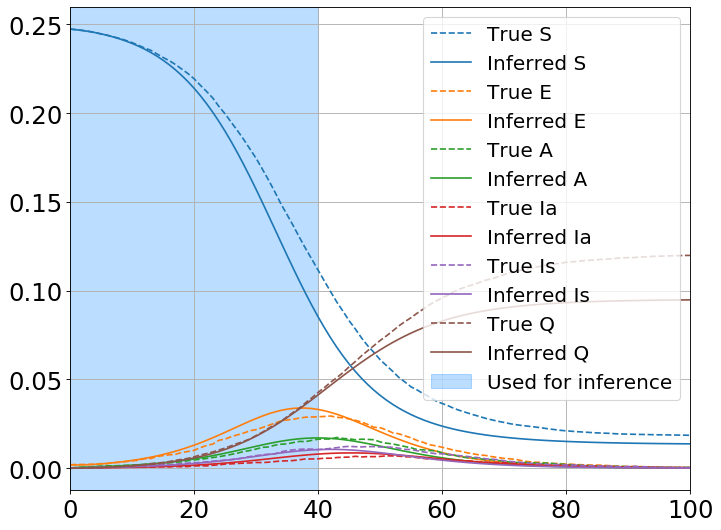

In [21]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = pyross.deterministic.SEAIRQ(best_estimates, int(M), fi)
x0 = params[6:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('latent_SEAIRQ_traj.npy').astype('float')/N 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S', ls='--', c='C0')
plt.plot(x_det[:, 0], label='Inferred S', c='C0')
plt.plot(x[:,1*M], label='True E', ls='--', c='C1')
plt.plot(x_det[:, 1*M], label='Inferred E', c='C1')
plt.plot(x[:,2*M], label='True A', ls='--', c='C2')
plt.plot(x_det[:, 2*M], label='Inferred A', c='C2')
plt.plot(x[:,3*M], label='True Ia', ls='--', c='C3')
plt.plot(x_det[:, 3*M], label='Inferred Ia', c='C3')
plt.plot(x[:,4*M], label='True Is', ls='--', c='C4')
plt.plot(x_det[:, 4*M], label='Inferred Is', c='C4')
plt.plot(x[:,5*M], label='True Q', ls='--', c='C5')
plt.plot(x_det[:, 5*M], label='Inferred Q', c='C5')

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

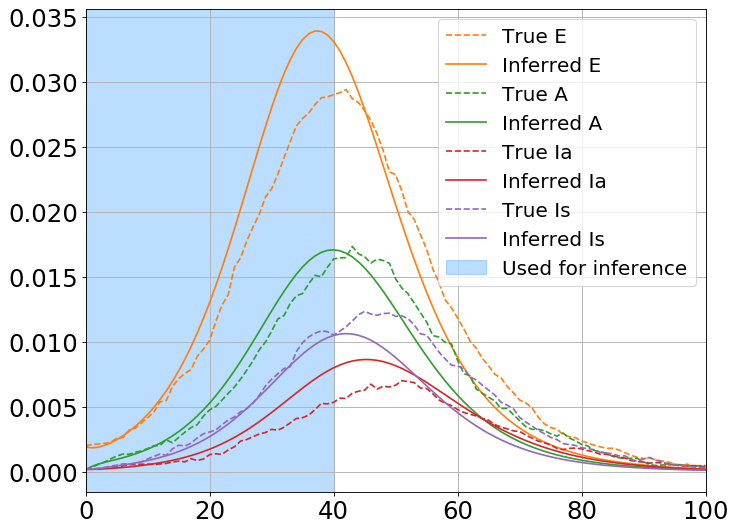

In [22]:
# replot the infected and exposed
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,1*M], label='True E', ls='--', c='C1')
plt.plot(x_det[:, 1*M], label='Inferred E', c='C1')
plt.plot(x[:,2*M], label='True A', ls='--', c='C2')
plt.plot(x_det[:, 2*M], label='Inferred A', c='C2')
plt.plot(x[:,3*M], label='True Ia', ls='--', c='C3')
plt.plot(x_det[:, 3*M], label='Inferred Ia', c='C3')
plt.plot(x[:,4*M], label='True Is', ls='--', c='C4')
plt.plot(x_det[:, 4*M], label='Inferred Is', c='C4')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()